In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [15]:
def marginOfError(model, X_test, X_train, y_test, y_train):
    test_pred = model.predict(X_test)
    train_pred = model.predict(X_train)

    testCounts = getErrorMargins(y_test, test_pred)
    trainCounts = getErrorMargins(y_train, train_pred)

    plt.figure()
    plt.plot(range(30), testCounts, label="Testing Set")
    plt.plot(range(30), trainCounts, label="Training Set")
    plt.title("Final Position Margin of Error")
    plt.xlabel("Margin of Error (Positions)")
    plt.ylabel("Proportion Correct")
    plt.xlim(0, 30)
    plt.ylim(0, 1)
    plt.legend(loc='best')
    plt.show()

In [16]:
def getErrorMargins(y_actual, y_pred):
    y = y_actual.values.astype(float)
    counts = np.zeros(30)
    total = len(y)

    diff = np.zeros(total)
    for index in range(total):
        temp = abs(y[index] - y_pred[index])
        diff[index] = abs(y[index] - y_pred[index])

    for val in diff:
        for index in range(len(counts)):
            if val < index:
                counts[index] += 1

    x = sum(diff) / total
    counts = counts / total
    return counts

Epoch 1/100
136/136 [==============================] - 1s 4ms/step - loss: 18.8673 - mae: 18.8673 - val_loss: 17.8256 - val_mae: 17.8256
Epoch 2/100
136/136 [==============================] - 0s 3ms/step - loss: 17.5866 - mae: 17.5866 - val_loss: 16.6578 - val_mae: 16.6578
Epoch 3/100
136/136 [==============================] - 0s 3ms/step - loss: 16.4637 - mae: 16.4637 - val_loss: 15.6336 - val_mae: 15.6336
Epoch 4/100
136/136 [==============================] - 0s 3ms/step - loss: 15.4774 - mae: 15.4774 - val_loss: 14.7425 - val_mae: 14.7425
Epoch 5/100
136/136 [==============================] - 0s 3ms/step - loss: 14.6064 - mae: 14.6064 - val_loss: 13.9502 - val_mae: 13.9502
Epoch 6/100
136/136 [==============================] - 0s 3ms/step - loss: 13.8259 - mae: 13.8259 - val_loss: 13.2464 - val_mae: 13.2464
Epoch 7/100
136/136 [==============================] - 0s 3ms/step - loss: 13.1340 - mae: 13.1340 - val_loss: 12.6260 - val_mae: 12.6260
Epoch 8/100
136/136 [====================

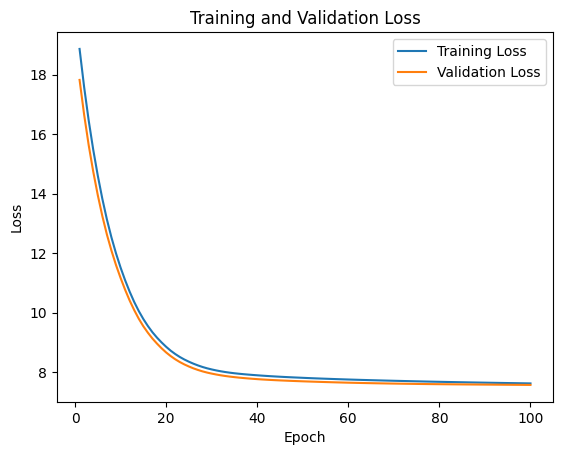

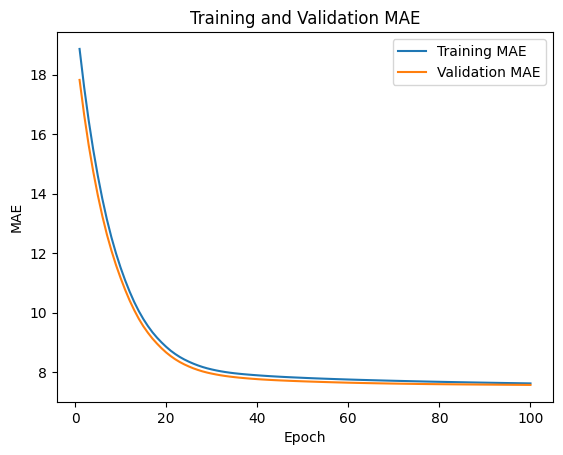

136/136 [==============================] - 0s 3ms/step


<ipython-input-16-69081458b4ec>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  diff[index] = abs(y[index] - y_pred[index])


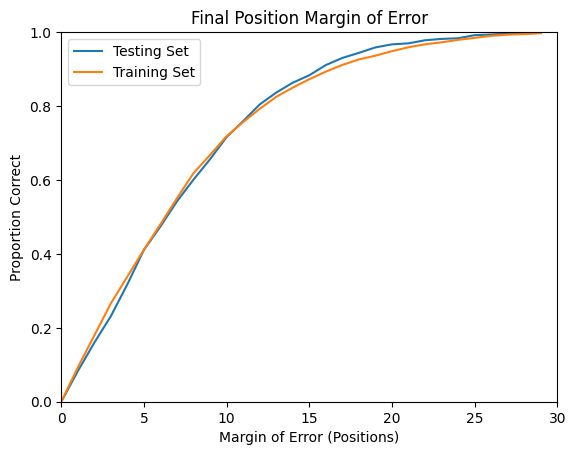

In [19]:
#Loads the dataset from github
data = pd.read_csv("https://raw.githubusercontent.com/ML-Racer-Performance-Prediction/NASCAR/main/Documentation/NASCAR%20Full%20Stats%20(2).csv")

# Separates the features and target
X = data.drop('EndingPosition', axis=1)
Y = data['EndingPosition']

# Features
categorical_cols = ['Track', 'Driver', 'Sponsor', 'Owner', 'CarManufacturer', 'TrackType']
numerical_cols = ['StartingPosition', 'CarNumber']

# Splits the dataset. 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=18)

# One-hot encoding the categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
X_train_categorical = categorical_transformer.fit_transform(X_train[categorical_cols]).toarray()
X_test_categorical = categorical_transformer.transform(X_test[categorical_cols]).toarray()

# Feature scaling the numerical features
numerical_transformer = StandardScaler()
X_train_numerical = numerical_transformer.fit_transform(X_train[numerical_cols])
X_test_numerical = numerical_transformer.transform(X_test[numerical_cols])

# Combining the categorical and numerical features back together
X_train_combined = np.concatenate([X_train_categorical, X_train_numerical], axis=1)
X_test_combined = np.concatenate([X_test_categorical, X_test_numerical], axis=1)

# Builds the single layer perceptron model.
SLP = Sequential([
    Dense(1, activation='linear', input_shape=(X_train_combined.shape[1],)),
])

# Compiles the model with SGD, lr of 0.001, and a momentum of 0.8
optimizer = SGD(learning_rate=0.001, momentum=0.8)
SLP.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

# Early stopping to prevent overfitting
stop_early = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model with a batch size of 32 and maximum of 100 epochs
history = SLP.fit(X_train_combined, y_train, epochs=100, batch_size=32, validation_data=(X_test_combined, y_test), callbacks=[stop_early])

# Gets the loss histories
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']

# Evaluates the model on the test set
test_loss = SLP.evaluate(X_test_combined, y_test, verbose=0)
print(f'Test MAE: {test_loss}')

# Makes predictions
y_pred = SLP.predict(X_test_combined)

# Calculates MAE, MSE, and R-squared, then prints results
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plots the training and validation loss
plt.figure()
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plots the training and validation MAE
plt.figure()
plt.plot(range(1, len(train_mae) + 1), train_mae, label='Training MAE')
plt.plot(range(1, len(val_mae) + 1), val_mae, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

marginOfError(SLP, X_test_combined, X_train_combined, y_test, y_train)